In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


In [2]:
import gbtoolbox.bounds as bounds
import gbtoolbox.misc as mt
import gbtoolbox.dft as dft
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate
import torch.nn as nn
import torch.nn.functional as F
import math
print(torch.__version__)
from datetime import datetime
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

/home/jonathan/miniconda/envs/torch_fall23/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jonathan/miniconda/envs/torch_fall23/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/jonathan/miniconda/envs/torch_fall23/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jonathan/miniconda/envs/torch_fall23/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


2.1.0.dev20230830


Here we are going to consider the dataset Cifar10. We transform it to Grayscale as a standard simplification although we don't have to do that.

In [3]:
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])
#,transforms.Grayscale(num_output_channels=1)
#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
batch_size = 40

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


print(trainset.classes)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)




Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Files already downloaded and verified


[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 1]
torch.Size([10000, 1, 32, 32])


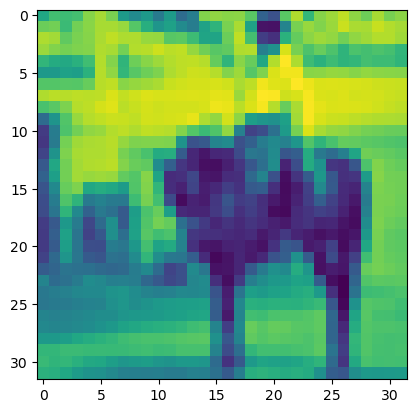

In [4]:
train_set_array = transforms.Grayscale()(torch.Tensor(np.transpose(trainset.data,(0,3,1,2))))
test_set_array = transforms.Grayscale()(torch.Tensor(np.transpose(testset.data,(0,3,1,2))))
train_set_targs = np.array(trainset.targets)
test_set_targs = np.array(testset.targets)
train_set_targs[train_set_targs!=5]=0
train_set_targs[train_set_targs==5]=1
test_set_targs[test_set_targs!=5]=0
test_set_targs[test_set_targs==5]=1
print(test_set_targs[:40])
print(test_set_array.shape)
plt.imshow(train_set_array[11,0,:,:])


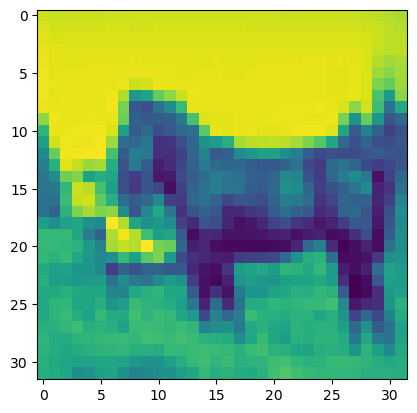

In [5]:
plt.imshow(train_set_array[12,0,:,:])

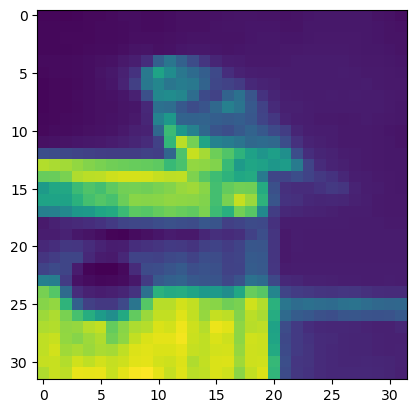

In [6]:
plt.imshow(train_set_array[13,0,:,:])

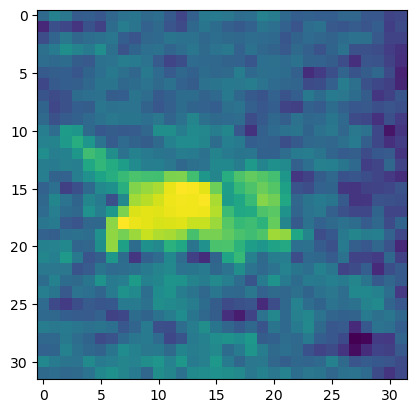

In [7]:
plt.imshow(train_set_array[39,0,:,:])

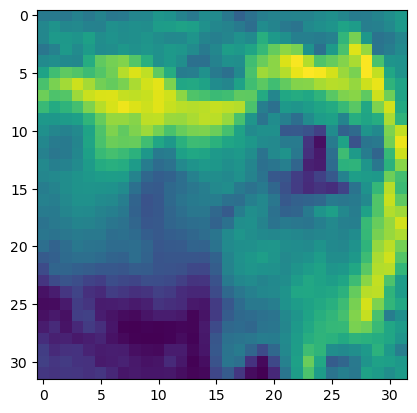

In [8]:
plt.imshow(train_set_array[40,0,:,:])

Our target of choice is the dog.

In [9]:

train_set_array=train_set_array.numpy().reshape(-1,32*32)
test_set_array=test_set_array.numpy().reshape(-1,32*32)

Since we are using PCA here, we are considering flat arrays.

In [10]:
print(train_set_array.shape)
#ss=StandardScaler()
#ms=MinMaxScaler((-1,1))

#ss.fit(train_set_array.numpy().reshape(-1,32*32))
#train_set_array=ss.transform(train_set_array.numpy().reshape(-1,32*32))
#test_set_array=ss.transform(test_set_array.numpy().reshape(-1,32*32))
print(test_set_array[:4,:20])

pca = PCA(n_components=8).fit(train_set_array)
train_set_array = pca.transform(train_set_array)
test_set_array = pca.transform(test_set_array)

amax = np.max(np.abs(train_set_array))
train_set_array=train_set_array/amax
test_set_array=test_set_array/amax

#ms.fit(train_set_array)
#train_set_array = ms.transform(train_set_array)
#test_set_array = ms.transform(test_set_array)
print(test_set_array[:4,:])

(50000, 1024)
[[118.5562   118.0401   123.22451  124.9254   118.81201  115.2854
  121.284805 118.9861   117.39919  118.530106 120.8889   118.909004
  118.8659   122.9704   124.3231   125.682    123.155304 119.08481
  117.427    118.47001 ]
 [234.9765   230.9769   231.9768   231.9768   231.9768   231.9768
  231.9768   231.9768   231.9768   231.9768   232.9767   232.9767
  232.9767   232.9767   232.9767   232.3897   231.80269  231.5038
  232.37889  231.966   ]
 [184.0642   181.84721  161.1051   153.4048   188.2164   203.39981
  206.88332  211.9537   215.73611  218.93152  220.60008  216.3294
  226.9432   230.31271  233.38332  235.79599  218.6837   231.68239
  236.68192  238.8065  ]
 [154.88751  174.5463   179.68141  192.86499  184.5283   170.8564
  172.4002   171.6884   174.286    180.12212  184.7303   185.79031
  186.3773   185.79031  183.37761  182.7906   180.6768   179.965
  183.96461  186.0784  ]]
[[-0.12751473 -0.01538187 -0.04962166  0.15279143 -0.06715682  0.00344461
  -0.00256763 

There are a number of ways we can make sure that our data is between -1 and 1. We picked this one here to not lose scale information.

In [11]:
testset = TensorDataset(torch.Tensor(test_set_array),torch.Tensor(test_set_targs)) # create your datset
trainset = TensorDataset(torch.Tensor(train_set_array),torch.Tensor(train_set_targs)) # create your datset
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [12]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [13]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [14]:
MM=80000

This is a complicated problem, we want a large network.

In [15]:

class ShallowClassifier(nn.Module):
    def __init__(self):
        super(ShallowClassifier,self).__init__()
        self.fc1 = nn.Linear(8,MM)
        self.fc2 = nn.Linear(MM,1)     
        #self.fc1.weight = torch.nn.Parameter(torch.Tensor(wh.T))
        #self.fc1.bias = torch.nn.Parameter(torch.Tensor(tv*zv))      
        #self.fc2.bias = torch.nn.Parameter(torch.Tensor(np.array([np.mean(y)])))
        #self.fc2.weight = torch.nn.Parameter(torch.Tensor((sne)*(sv).reshape(-1,1).T/MM))
      
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
model = ShallowClassifier()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor ([9.0]))
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

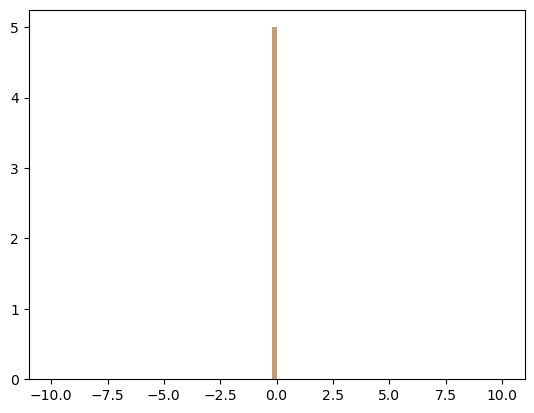

In [17]:
check_output = model(torch.Tensor(test_set_array))
plt.hist(check_output.detach().cpu().numpy()[test_set_targs>.5],alpha = 0.5,bins=100,density=True,range=(-10,10))
plt.hist(check_output.detach().cpu().numpy()[test_set_targs<.5],alpha = 0.5,bins=100,density=True,range=(-10,10))
plt.show()

In [18]:
loss = criterion(check_output, torch.Tensor(test_set_targs).reshape((-1, 1)))
print(loss)

tensor(1.2489, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [19]:
for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.reshape((-1, 1)))
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


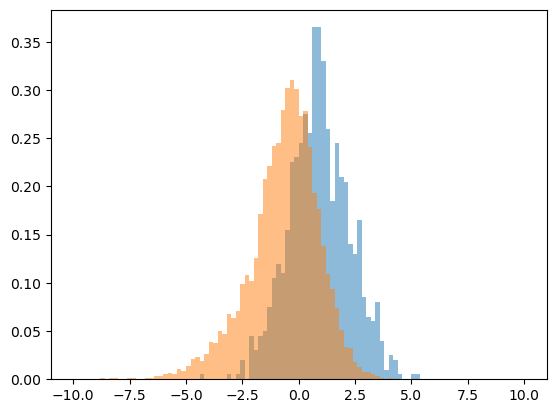

In [20]:
check_output = model(torch.Tensor(test_set_array))
plt.hist(check_output.detach().cpu().numpy()[test_set_targs>.5],alpha = 0.5,bins=100,density=True,range=(-10,10))
plt.hist(check_output.detach().cpu().numpy()[test_set_targs<.5],alpha = 0.5,bins=100,density=True,range=(-10,10))
plt.show()

In [21]:
loss = criterion(check_output, torch.Tensor(test_set_targs).reshape((-1, 1)))
print(loss)

tensor(1.0205, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [22]:
print(train_set_array)
tmin = np.min(train_set_array,axis=0)
tmax = np.max(train_set_array,axis=0)
print(tmax,tmin)
fmax=np.ones(8)
fmin=np.ones(8)
fmax[0]=np.max(np.fft.fftshift(np.fft.fftfreq(100,(tmin[0]-tmax[0])/100.)))
fmax[1]=np.max(np.fft.fftshift(np.fft.fftfreq(100,(tmin[1]-tmax[1])/100.)))
fmax[2]=np.max(np.fft.fftshift(np.fft.fftfreq(100,(tmin[2]-tmax[2])/100.)))
fmax[3]=np.max(np.fft.fftshift(np.fft.fftfreq(100,(tmin[3]-tmax[3])/100.)))
fmax[4]=np.max(np.fft.fftshift(np.fft.fftfreq(100,(tmin[4]-tmax[4])/100.)))
fmax[5]=np.max(np.fft.fftshift(np.fft.fftfreq(100,(tmin[5]-tmax[5])/100.)))
fmax[6]=np.max(np.fft.fftshift(np.fft.fftfreq(100,(tmin[6]-tmax[6])/100.)))
fmax[7]=np.max(np.fft.fftshift(np.fft.fftfreq(100,(tmin[7]-tmax[7])/100.)))
fmin[0]=np.min(np.fft.fftshift(np.fft.fftfreq(100,(tmin[0]-tmax[0])/100.)))
fmin[1]=np.min(np.fft.fftshift(np.fft.fftfreq(100,(tmin[1]-tmax[1])/100.)))
fmin[2]=np.min(np.fft.fftshift(np.fft.fftfreq(100,(tmin[2]-tmax[2])/100.)))
fmin[3]=np.min(np.fft.fftshift(np.fft.fftfreq(100,(tmin[3]-tmax[3])/100.)))
fmin[4]=np.min(np.fft.fftshift(np.fft.fftfreq(100,(tmin[4]-tmax[4])/100.)))
fmin[5]=np.min(np.fft.fftshift(np.fft.fftfreq(100,(tmin[5]-tmax[5])/100.)))
fmin[6]=np.min(np.fft.fftshift(np.fft.fftfreq(100,(tmin[6]-tmax[6])/100.)))
fmin[7]=np.min(np.fft.fftshift(np.fft.fftfreq(100,(tmin[7]-tmax[7])/100.)))
print(fmax,fmin)

[[-0.19029751  0.12231278 -0.10715949 ...  0.02469806  0.00162772
  -0.1326042 ]
 [ 0.01189534 -0.04373954 -0.23696403 ...  0.01857744 -0.01422334
  -0.104937  ]
 [ 0.29199624 -0.47106874  0.09285267 ... -0.01076993 -0.05625581
   0.02446576]
 ...
 [-0.02458077 -0.44405407  0.04305102 ... -0.02624291 -0.03386974
   0.05828334]
 [ 0.40884805 -0.12850477 -0.2145463  ...  0.12383561  0.00228036
   0.05781287]
 [ 0.1538361  -0.05319189  0.17366382 ...  0.18011561 -0.07375321
  -0.04144308]]
[1.         0.8290835  0.6006669  0.6937036  0.47933134 0.4991832
 0.5161683  0.44916165] [-0.94063115 -0.71885884 -0.5813146  -0.6443301  -0.46443596 -0.47730997
 -0.491511   -0.44748798]
[25.76481366 32.3009435  42.30184424 37.36826725 52.97916077 51.20363463
 49.61896485 55.76314321] [-25.24951739 -31.65492463 -41.45580736 -36.62090191 -51.91957755
 -50.17956194 -48.62658556 -54.64788034]


In [23]:
test_mod_targs=test_set_targs*20-10
train_mod_targs=train_set_targs*20-10

This is a bit arbitrary, but we think about the target function which in this case is before we apply the sigmoid. We do this because then it is easier to calculate.

(43046721, 2)


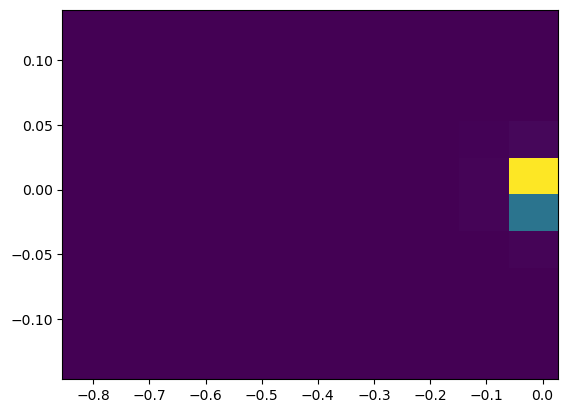

In [218]:
f, _ = mt.gen_stacked_equispaced_nd_grid(9,np.array([[fmin[j]/10,fmax[j]/10] for j in np.arange(8)]))
yf = (1/np.concatenate((train_set_array,test_set_array)).shape[0])*dft.nu_dft_cuda(np.concatenate((train_set_array,test_set_array)),np.concatenate((train_mod_targs,test_mod_targs)),f,128,128)/(np.sqrt(2*np.pi)**2)
print(yf.view("(2,)float").reshape(-1,2).shape)
plt.hist2d(yf.view("(2,)float").reshape(-1,2)[:,0],yf.view("(2,)float").reshape(-1,2)[:,1])
plt.show()

1458617.0


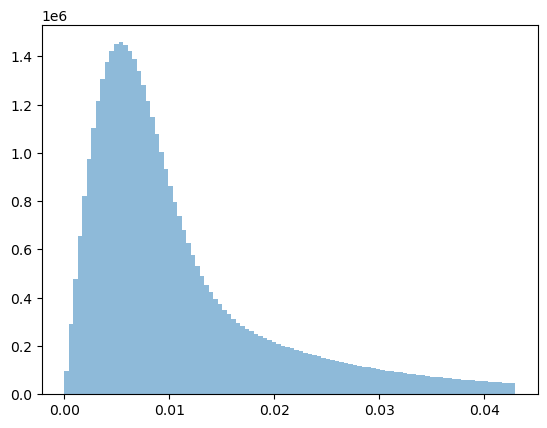

In [219]:
entries, bin_edges, patches = plt.hist(np.abs(yf),alpha = 0.5,bins=100, density=False,range=[0,.05*np.max(np.abs(yf))])
print(np.max(entries))

In [220]:
peak=np.argmax(entries, axis=None)
print(peak)
sigma=(bin_edges[peak]+1*bin_edges[peak+1])/2
print(sigma)

12
0.0053702446565243485


We find an effective $\sigma$ from the data. We assume the data is dominated by sampling induced noise.

2086094.0


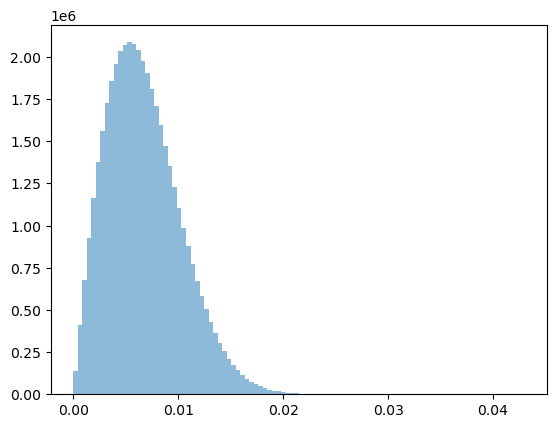

In [221]:
bentries, bbin_edges, bpatches = plt.hist(np.abs(np.random.normal(0, sigma, yf.shape[0])+1.j*np.random.normal(0, sigma, yf.shape[0])),alpha = 0.5,bins=100, density=False,range=[0,.05*np.max(np.abs(yf))])
print(np.max(bentries))

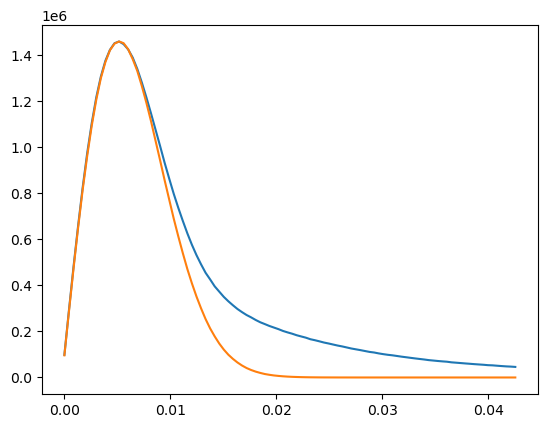

In [222]:
plt.plot(bin_edges[:100],entries)
plt.plot(bbin_edges[:100],bentries*np.max(entries)/np.max(bentries))

Then we have data and a noise induced sampling model and can select the component that seems free from the noise induced sampling. If we increase the portion that is noise we have a better fit

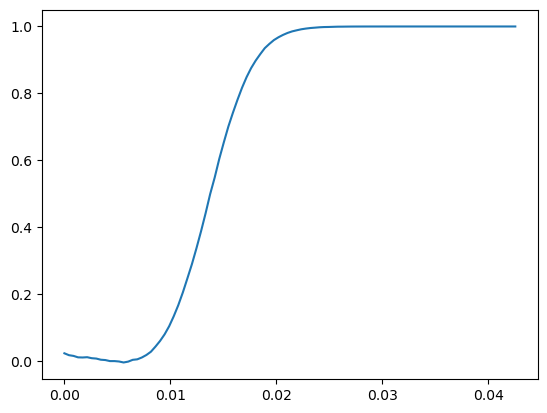

In [223]:
plt.plot(bin_edges[:100],(entries-bentries*np.max(entries)/np.max(bentries))/entries)

In [256]:
threshold=(bin_edges[:100])[np.abs(entries-bentries*np.max(entries)/np.max(bentries))>0.9999998*entries][0]
print(threshold)
yf[(np.abs(yf)<threshold)]=0

0.030073370076536352


Place a loose cut. We can go a little higher or lower as needed.

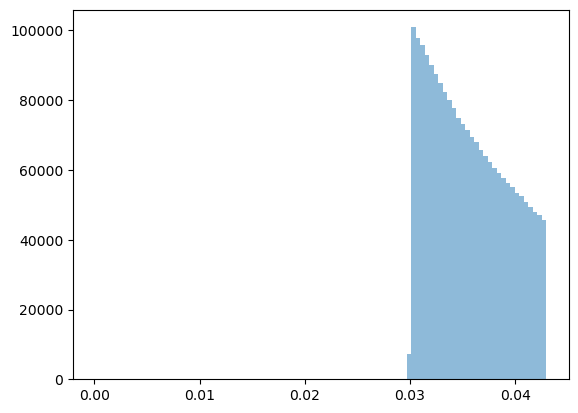

In [257]:
plt.hist(np.abs(yf),alpha = 0.5,bins=100, density=False,range=[0.0001,.05*np.max(np.abs(yf))])
plt.show()

In [258]:
pdf=bounds.E_pdf(yf,f.T*2*np.pi)
zv,tv,wv,sv = pdf.gen_ztw_c(MM)
hatw,wnorm = bounds.nn_wnorm(wv)

In [259]:
sne = bounds.est_spec_norm(f*2*np.pi,yf)
print(sne)

1.254156137658517e+18


Our Spectral Norm is very high, and so not useful here. We can probably place a very tight cut and get closer to a good value if we need to place a bound, but we can do a two step correction for initialization.

In [260]:

class ShallowClassifier(nn.Module):
    def __init__(self):
        super(ShallowClassifier,self).__init__()
        self.fc1 = nn.Linear(6,MM)
        self.fc2 = nn.Linear(MM,1)     
        self.fc1.weight = torch.nn.Parameter(torch.Tensor(hatw.T))
        self.fc1.bias = torch.nn.Parameter(torch.Tensor(tv*zv))      
        self.fc2.bias = torch.nn.Parameter(torch.Tensor(np.array([.0*np.mean(test_set_targs)])))
        self.fc2.weight = torch.nn.Parameter(torch.Tensor((-1)*(sv).reshape(-1,1).T/MM))
        print(self.fc1.weight)
        print(self.fc1.bias)
      
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [261]:
model2 = ShallowClassifier()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor ([9.0]))
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

Parameter containing:
tensor([[ 0.0769, -0.0641, -0.0641,  ...,  0.2179, -0.0641,  0.0769],
        [ 0.1806,  0.0387,  0.1097,  ..., -0.1742,  0.1806, -0.0323],
        [ 0.1393, -0.0410,  0.0492,  ..., -0.0410, -0.0410,  0.3197],
        ...,
        [ 0.1958,  0.1189, -0.2657,  ...,  0.1189, -0.0350, -0.0350],
        [ 0.2074, -0.1436,  0.0904,  ...,  0.2074,  0.0904, -0.0266],
        [-0.1060, -0.0331, -0.0331,  ..., -0.1060, -0.1060, -0.1788]],
       requires_grad=True)
Parameter containing:
tensor([-0.8829, -0.0026,  0.4887,  ..., -0.1873, -0.8887,  0.3850],
       requires_grad=True)


tensor([[-0.0028],
        [-0.0031],
        [-0.0029],
        ...,
        [-0.0026],
        [-0.0026],
        [-0.0028]], grad_fn=<AddmmBackward0>)


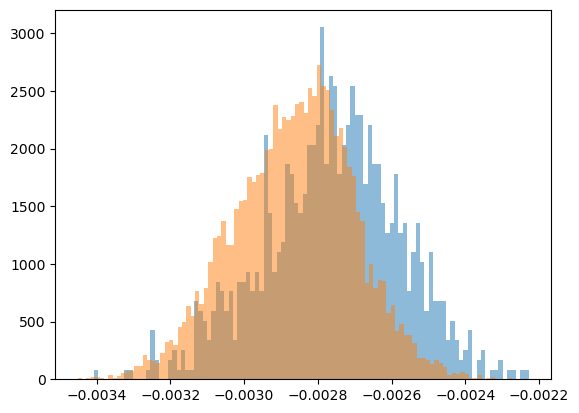

In [262]:
check_output = model2(torch.Tensor(test_set_array))
print(check_output)
plt.hist(check_output.detach().cpu().numpy()[test_set_targs>.5],alpha = 0.5,bins=100,density=True)
plt.hist(check_output.detach().cpu().numpy()[test_set_targs<.5],alpha = 0.5,bins=100,density=True)
plt.show()

In [263]:
loss = criterion(check_output, torch.Tensor(test_set_targs).reshape((-1, 1)))
print(loss)

tensor(1.2476, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


We see an improvement over the initial, but we can improve farther by using the output of the train set to rescale the outer bias and weights.